# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Normalize, Resize, ToTensor 
import os
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import random

In [2]:
!wget -O dataset.zip https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0

--2021-11-22 17:27:54--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/33l8lp62rmvtx40/dataset.zip [following]
--2021-11-22 17:27:54--  https://www.dropbox.com/s/raw/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4926b72c63b028726b56fdd019.dl.dropboxusercontent.com/cd/0/inline/Baeo75e65IzS4yhWaZjSImvL0cnjD-Tl-mQcUwXal2v7Nnp3L65uSFsSsXegT4NJD3nhqgkU4RSE3ubBCAh1fEUfn37j0-ZZklJA_RY2CCTWqmipQJMw8DYosgX7fzMtoivKqcBOAKMAe15tkmOtB3Vr/file# [following]
--2021-11-22 17:27:54--  https://uc4926b72c63b028726b56fdd019.dl.dropboxusercontent.com/cd/0/inline/Baeo75e65IzS4yhWaZjSImvL0cnjD-Tl-mQcUwXal2v7Nnp3L65uSFsSsXegT4NJD3nhqgkU4RSE3ubBCAh1fEUf

In [3]:
!unzip dataset.zip -d .

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./dataset/dataset/val/class_101/00048.jpg  
  inflating: ./dataset/dataset/val/class_101/00049.jpg  
   creating: ./dataset/dataset/val/class_102/
  inflating: ./dataset/dataset/val/class_102/00000.jpg  
  inflating: ./dataset/dataset/val/class_102/00001.jpg  
  inflating: ./dataset/dataset/val/class_102/00002.jpg  
  inflating: ./dataset/dataset/val/class_102/00003.jpg  
  inflating: ./dataset/dataset/val/class_102/00004.jpg  
  inflating: ./dataset/dataset/val/class_102/00005.jpg  
  inflating: ./dataset/dataset/val/class_102/00006.jpg  
  inflating: ./dataset/dataset/val/class_102/00007.jpg  
  inflating: ./dataset/dataset/val/class_102/00008.jpg  
  inflating: ./dataset/dataset/val/class_102/00009.jpg  
  inflating: ./dataset/dataset/val/class_102/00010.jpg  
  inflating: ./dataset/dataset/val/class_102/00011.jpg  
  inflating: ./dataset/dataset/val/class_102/00012.jpg  
  inflating: ./dataset/dataset/

In [4]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
# фиксируем random seed
set_random_seed(42)

### Подготовка данных

In [ ]:
means = []
vars = []
for image, label in train_dataset:
  means.append(image.mean(dim=(1, 2)))
  vars.append(image.std(dim=(1, 2)))

In [ ]:
print(torch.stack(means).mean(dim=0))
print(torch.stack(vars).mean(dim=0))

tensor([1.1363, 1.2399, 1.3753])
tensor([0.4998, 0.4998, 0.4998])


При написании кода ориентировалась на архитектуру и код по статье: 
https://github.com/FrancescoSaverioZuppichini/ResNet


In [38]:
class MyResBlock(nn.Module): 
    def __init__(self, in_channels, out_channels): 
        super().__init__() 
        self.in_channels, self.out_channels = in_channels, out_channels 
        self.block1 = nn.Sequential( 
            torch.nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=(1, 1)), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm2d(self.out_channels), 
            torch.nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=(1, 1)), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm2d(self.out_channels) 
        ) 
        self.block2 = nn.Sequential( 
            torch.nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=(1, 1)), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm2d(self.out_channels), 
            torch.nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=(1, 1)), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm2d(self.out_channels) 
        ) 
        self.activate = torch.nn.ReLU() 
    
    def forward(self, x): 
        residual = x 
        x = self.block1(x) 
        x += residual 
        x = self.activate(x) 
        residual = x 
        x = self.block2(x) 
        x += residual 
        x = self.activate(x) 
        return x


In [ ]:
model1 = nn.Sequential(
        torch.nn.Conv2d(3, 16, 3),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16),

        torch.nn.Conv2d(16, 32, 3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(32),

        torch.nn.Conv2d(32, 64, 3, padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(64),

        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),

        torch.nn.MaxPool2d(2),

        torch.nn.Conv2d(64, 128, 3, padding=(1, 1)),
        torch.nn.ReLU(),

        torch.nn.BatchNorm2d(128),

        MyResBlock(128, 128),
        MyResBlock(128, 128),
        MyResBlock(128, 128),
        MyResBlock(128, 128),
        
        torch.nn.MaxPool2d(2),

        torch.nn.Flatten(),
        
        torch.nn.Linear(1152, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(1024, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, 200)
)

In [ ]:
model2 = nn.Sequential(
        torch.nn.Conv2d(3, 16, 3),
        torch.nn.BatchNorm2d(16),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(16, 32, 3),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),

        torch.nn.Conv2d(32, 64, 3, padding=(1, 1)),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
       
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        torch.nn.MaxPool2d(2),

        torch.nn.Conv2d(64, 128, 3, padding=(1, 1)),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),

        MyResBlock(128, 128),
        MyResBlock(128, 128),
        MyResBlock(128, 128),
        MyResBlock(128, 128),
        MyResBlock(128, 128),
        torch.nn.MaxPool2d(2),

        torch.nn.Flatten(),
        
        torch.nn.Linear(1152, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(1024, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, 200)
)

In [15]:
model3 = nn.Sequential(
        torch.nn.Conv2d(3, 16, 3),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16),

        torch.nn.Conv2d(16, 32, 3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(32),
        
        torch.nn.Conv2d(32, 32, 3),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(32),

        torch.nn.Conv2d(32, 64, 3, padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(64),

        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        torch.nn.MaxPool2d(2),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),

        torch.nn.Conv2d(64, 128, 3, padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(128),

        MyResBlock(128, 128),
        torch.nn.MaxPool2d(kernel_size=2),

        torch.nn.Flatten(),
        
        torch.nn.Linear(128, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(1024, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(128, 256)
)

In [ ]:
model4 = nn.Sequential(
        torch.nn.Conv2d(3, 16, 3),
        torch.nn.BatchNorm2d(16),
        torch.nn.ReLU(),

        torch.nn.Conv2d(16, 32, 3),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),

        torch.nn.Conv2d(32, 64, 3, padding=(1, 1)),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),

        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),

        torch.nn.MaxPool2d(2),

        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),

        torch.nn.Conv2d(64, 128, 3, padding=(1, 1)),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),

        MyResBlock(128, 128),
        torch.nn.MaxPool2d(kernel_size=2),

        torch.nn.Flatten(),
        
        torch.nn.Linear(128, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(128, 256)
)

In [39]:
block1 = nn.Sequential( 
        torch.nn.Conv2d(3, 16, 3),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16))
block2 = nn.Sequential( 
        torch.nn.Conv2d(16, 32, 3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(32))
block3 = nn.Sequential(
        torch.nn.Conv2d(32, 64, 3, padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.BatchNorm2d(64))
block4 = nn.Sequential(
        torch.nn.Conv2d(64, 128, 3, padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(128),
        torch.nn.MaxPool2d(2))
block5 = nn.Sequential(
        torch.nn.Conv2d(128, 128, 3, padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(128),
        torch.nn.MaxPool2d(2))
model5 = nn.Sequential(
        block1,
        block2,
        block3,
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        torch.nn.MaxPool2d(2),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        MyResBlock(64, 64),
        block4,
        block5,
        torch.nn.Flatten(),
        torch.nn.Linear(128, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, 256)
)

In [8]:
train_transform = transforms.Compose([
     transforms.ColorJitter(hue=.05, saturation=.05),
     transforms.RandomHorizontalFlip(p=0.5),
     #transforms.RandomRotation(20, interpolation=transforms.functional.InterpolationMode.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize(
         mean=[1.1363, 1.2399, 1.3753], 
         std=[0.4998, 0.4998, 0.4998])
])

val_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(
         mean=[1.1363, 1.2399, 1.3753], 
         std=[0.4998, 0.4998, 0.4998])
])

train_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/val", transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2) #bs
val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [9]:
loss_val = 0
loss_acc = 0
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    global loss_val, loss_acc
    model.to(device).train()
    train_loss = 0.
    train_size = 0
    all_losses = []
    pred_classes = np.array([])
    true_labels = np.array([])
    for images, labels in train_dataloader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      y_predict = model(images)  ### -> model.forward(x=images)
      loss = criterion(y_predict, labels)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
      pred_classes = np.append(pred_classes, y_predict.argmax(1).cpu().detach().numpy()) 
      true_labels = np.append(true_labels, labels.cpu().detach().numpy())
      train_size += 1
    total_loss = train_loss / train_size
    train_acc =  (pred_classes == true_labels).mean()
    metrics = {'Loss': total_loss, 'Accuracy': train_acc}
    return metrics


def predict(model, val_dataloder, criterion, device="cuda:0"):
    global loss_val, loss_acc
    model.to(device).eval()

    val_loss = 0.
    val_size = 0
    losses = []
    predicted_classes = np.array([])
    true_classes = np.array([])

    for images, labels in val_dataloder:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      prediction = model(images)
      loss = criterion(prediction, labels)
      
      val_loss += loss.item()
      losses.append(loss.item())
      predicted_classes = np.append(predicted_classes, prediction.argmax(1).cpu().detach().numpy())
      true_classes = np.append(true_classes, labels.cpu().detach().numpy())
      val_size += 1

    loss_val = val_loss / val_size
    loss_acc = (predicted_classes == true_classes).mean()
    print('Val loss: {:.2f}'.format(loss_val), 'Val accuracy: {:.2f}'.format(loss_acc))
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    global loss_val, loss_acc
    for epoch in range(n_epochs):
        metrics = train_one_epoch(model, train_dataloader, criterion, optimizer, device=device)
        print('Train epoch: {}'.format(epoch + 1))
        print('Train loss: {:.2f}'.format(metrics['Loss']), 'Train accuracy: {:.2f}'.format(metrics['Accuracy']))
        print('Validation epoch: {}'.format(epoch + 1))
        with torch.no_grad():
            all_losses, total_predictions, total_labels = predict(model, val_dataloader, criterion, device=device) 
        
        wandb.log({
                  'Train loss': metrics['Loss'],
                  'Train accuracy': metrics['Accuracy'],
                  'Val loss': loss_val,
                  'Val accuracy': loss_acc})

In [10]:
pip install wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 140 kB 42.9 MB/s 
     |████████████████████████████████| 180 kB 46.9 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=a77eeefe4907cebe670ea1748cb569d584bb4418d826cc28216e48a75e99147f
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=182e4bb710a929b0bb5e9d17290317fc88ed6b11c33d932db37bc8bf46c4c552
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [27]:
import wandb
wandb.login()
wandb.init(project="hw2_iad")
wandb.watch(model);

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Train accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
Train loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Val accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇███▇████▇█
Val loss,█▆▅▄▃▃▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁
Train accuracy,0.54803
Train loss,1.73203
Val accuracy,0.3707
Val loss,2.82585


### Обучение модели, запуски экспериментов

In [35]:
model = model5
criterion = nn.CrossEntropyLoss()
n_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
scheduler = None

Простой тест на проверку правильности написанного кода

In [18]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Val loss: 3.39 Val accuracy: 0.21
tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(model1, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
Train loss 3.86; train accuracy 0.14
Validation Epoch: 0
Val loss 3.78; Val accuracy 0.16
Train Epoch: 1
Train loss 3.59; train accuracy 0.18
Validation Epoch: 1
Val loss 3.53; Val accuracy 0.20
Train Epoch: 2
Train loss 3.40; train accuracy 0.22
Validation Epoch: 2
Val loss 3.40; Val accuracy 0.22
Train Epoch: 3
Train loss 3.23; train accuracy 0.25
Validation Epoch: 3
Val loss 3.52; Val accuracy 0.20
Train Epoch: 4
Train loss 3.10; train accuracy 0.28
Validation Epoch: 4
Val loss 3.23; Val accuracy 0.26
Train Epoch: 5
Train loss 3.00; train accuracy 0.29
Validation Epoch: 5
Val loss 3.18; Val accuracy 0.27
Train Epoch: 6
Train loss 2.89; train accuracy 0.32
Validation Epoch: 6
Val loss 3.15; Val accuracy 0.27
Train Epoch: 7
Train loss 2.81; train accuracy 0.33
Validation Epoch: 7
Val loss 2.95; Val accuracy 0.31
Train Epoch: 8
Train loss 2.74; train accuracy 0.34
Validation Epoch: 8
Val loss 2.96; Val accuracy 0.31
Train Epoch: 9
Train loss 2.67; train accuracy 0.36
Val

In [ ]:
#model1, 17 wandb
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 5.01 Train accuracy: 0.02
Validation epoch: 1
Val loss: 4.70 Val accuracy: 0.05
Train epoch: 2
Train loss: 4.38 Train accuracy: 0.08
Validation epoch: 2
Val loss: 4.22 Val accuracy: 0.09
Train epoch: 3
Train loss: 3.96 Train accuracy: 0.13
Validation epoch: 3
Val loss: 4.07 Val accuracy: 0.12
Train epoch: 4
Train loss: 3.68 Train accuracy: 0.17
Validation epoch: 4
Val loss: 3.64 Val accuracy: 0.18
Train epoch: 5
Train loss: 3.47 Train accuracy: 0.21
Validation epoch: 5
Val loss: 3.59 Val accuracy: 0.19
Train epoch: 6
Train loss: 3.31 Train accuracy: 0.23
Validation epoch: 6
Val loss: 3.62 Val accuracy: 0.19
Train epoch: 7
Train loss: 3.19 Train accuracy: 0.26
Validation epoch: 7
Val loss: 3.27 Val accuracy: 0.24
Train epoch: 8
Train loss: 3.08 Train accuracy: 0.28
Validation epoch: 8
Val loss: 3.25 Val accuracy: 0.25
Train epoch: 9
Train loss: 2.99 Train accuracy: 0.30
Validation epoch: 9
Val loss: 3.25 Val accuracy: 0.24
Train epoch: 10
Train loss: 2.90 Trai

In [ ]:
#final_model, 19 wandb
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 4.68 Train accuracy: 0.06
Validation epoch: 1
Val loss: 4.28 Val accuracy: 0.09
Train epoch: 2
Train loss: 3.86 Train accuracy: 0.15
Validation epoch: 2
Val loss: 3.90 Val accuracy: 0.15
Train epoch: 3
Train loss: 3.48 Train accuracy: 0.21
Validation epoch: 3
Val loss: 3.52 Val accuracy: 0.21
Train epoch: 4
Train loss: 3.27 Train accuracy: 0.25
Validation epoch: 4
Val loss: 3.35 Val accuracy: 0.24
Train epoch: 5
Train loss: 3.10 Train accuracy: 0.28
Validation epoch: 5
Val loss: 3.26 Val accuracy: 0.26


In [ ]:
#model3, 20 wandb
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 4.82 Train accuracy: 0.04
Validation epoch: 1
Val loss: 4.50 Val accuracy: 0.05
Train epoch: 2
Train loss: 4.22 Train accuracy: 0.09
Validation epoch: 2
Val loss: 4.16 Val accuracy: 0.10
Train epoch: 3
Train loss: 3.85 Train accuracy: 0.14
Validation epoch: 3
Val loss: 3.87 Val accuracy: 0.14
Train epoch: 4
Train loss: 3.60 Train accuracy: 0.18
Validation epoch: 4
Val loss: 3.59 Val accuracy: 0.18
Train epoch: 5
Train loss: 3.42 Train accuracy: 0.21
Validation epoch: 5
Val loss: 3.64 Val accuracy: 0.19


In [ ]:
#model4, 21 wandb
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 4.95 Train accuracy: 0.03
Validation epoch: 1
Val loss: 4.73 Val accuracy: 0.03
Train epoch: 2
Train loss: 4.44 Train accuracy: 0.06
Validation epoch: 2
Val loss: 4.66 Val accuracy: 0.06
Train epoch: 3
Train loss: 4.09 Train accuracy: 0.10
Validation epoch: 3
Val loss: 4.29 Val accuracy: 0.10
Train epoch: 4
Train loss: 3.84 Train accuracy: 0.14
Validation epoch: 4
Val loss: 3.84 Val accuracy: 0.14
Train epoch: 5
Train loss: 3.65 Train accuracy: 0.17
Validation epoch: 5
Val loss: 4.31 Val accuracy: 0.11


In [ ]:
#model3, 22 wandb, bs = 512
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 4.98 Train accuracy: 0.03
Validation epoch: 1
Val loss: 5.06 Val accuracy: 0.04
Train epoch: 2
Train loss: 4.38 Train accuracy: 0.08
Validation epoch: 2
Val loss: 4.28 Val accuracy: 0.09
Train epoch: 3
Train loss: 3.98 Train accuracy: 0.13
Validation epoch: 3
Val loss: 4.07 Val accuracy: 0.12
Train epoch: 4
Train loss: 3.70 Train accuracy: 0.17
Validation epoch: 4
Val loss: 3.77 Val accuracy: 0.16


In [ ]:
#model3, 24 wandb, bs = 256, without rotation
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 4.85 Train accuracy: 0.03
Validation epoch: 1
Val loss: 4.50 Val accuracy: 0.06
Train epoch: 2
Train loss: 4.18 Train accuracy: 0.09
Validation epoch: 2
Val loss: 4.07 Val accuracy: 0.11
Train epoch: 3
Train loss: 3.79 Train accuracy: 0.15
Validation epoch: 3
Val loss: 3.58 Val accuracy: 0.18
Train epoch: 4
Train loss: 3.54 Train accuracy: 0.19
Validation epoch: 4
Val loss: 3.48 Val accuracy: 0.20
Train epoch: 5
Train loss: 3.35 Train accuracy: 0.22
Validation epoch: 5
Val loss: 3.41 Val accuracy: 0.21
Train epoch: 6
Train loss: 3.19 Train accuracy: 0.25
Validation epoch: 6
Val loss: 3.24 Val accuracy: 0.24
Train epoch: 7
Train loss: 3.07 Train accuracy: 0.28
Validation epoch: 7
Val loss: 3.24 Val accuracy: 0.25
Train epoch: 8
Train loss: 2.95 Train accuracy: 0.30
Validation epoch: 8
Val loss: 3.11 Val accuracy: 0.26
Train epoch: 9
Train loss: 2.85 Train accuracy: 0.32
Validation epoch: 9
Val loss: 3.06 Val accuracy: 0.29
Train epoch: 10
Train loss: 2.75 Trai

In [ ]:
#model3, 24 wandb, bs = 256, without rotation
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 4.92 Train accuracy: 0.03
Validation epoch: 1
Val loss: 4.72 Val accuracy: 0.04
Train epoch: 2
Train loss: 4.24 Train accuracy: 0.08
Validation epoch: 2
Val loss: 4.36 Val accuracy: 0.09
Train epoch: 3
Train loss: 3.85 Train accuracy: 0.13
Validation epoch: 3
Val loss: 3.90 Val accuracy: 0.13
Train epoch: 4
Train loss: 3.59 Train accuracy: 0.18
Validation epoch: 4
Val loss: 3.61 Val accuracy: 0.19
Train epoch: 5
Train loss: 3.40 Train accuracy: 0.21
Validation epoch: 5
Val loss: 3.39 Val accuracy: 0.21


In [21]:
#model3, 25 wandb, bs = 256, without rotation + myres(64) after 
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 3.30 Train accuracy: 0.23
Validation epoch: 1
Val loss: 3.31 Val accuracy: 0.23
Train epoch: 2
Train loss: 3.14 Train accuracy: 0.26
Validation epoch: 2
Val loss: 3.17 Val accuracy: 0.26
Train epoch: 3
Train loss: 3.01 Train accuracy: 0.28
Validation epoch: 3
Val loss: 3.18 Val accuracy: 0.26
Train epoch: 4
Train loss: 2.90 Train accuracy: 0.31
Validation epoch: 4
Val loss: 3.05 Val accuracy: 0.29
Train epoch: 5
Train loss: 2.81 Train accuracy: 0.33
Validation epoch: 5
Val loss: 2.90 Val accuracy: 0.31
Train epoch: 6
Train loss: 2.71 Train accuracy: 0.34
Validation epoch: 6
Val loss: 2.98 Val accuracy: 0.30
Train epoch: 7
Train loss: 2.63 Train accuracy: 0.36
Validation epoch: 7
Val loss: 2.99 Val accuracy: 0.31
Train epoch: 8
Train loss: 2.55 Train accuracy: 0.38
Validation epoch: 8
Val loss: 2.81 Val accuracy: 0.34
Train epoch: 9
Train loss: 2.48 Train accuracy: 0.39
Validation epoch: 9
Val loss: 2.81 Val accuracy: 0.34
Train epoch: 10
Train loss: 2.41 Trai

In [30]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train epoch: 1
Train loss: 3.24 Train accuracy: 0.25
Validation epoch: 1
Val loss: 3.15 Val accuracy: 0.27
Train epoch: 2
Train loss: 2.95 Train accuracy: 0.30
Validation epoch: 2
Val loss: 3.00 Val accuracy: 0.29
Train epoch: 3
Train loss: 2.74 Train accuracy: 0.34
Validation epoch: 3
Val loss: 2.85 Val accuracy: 0.33
Train epoch: 4
Train loss: 2.59 Train accuracy: 0.37
Validation epoch: 4
Val loss: 2.74 Val accuracy: 0.35
Train epoch: 5
Train loss: 2.45 Train accuracy: 0.40
Validation epoch: 5
Val loss: 2.74 Val accuracy: 0.35
Train epoch: 6
Train loss: 2.33 Train accuracy: 0.42
Validation epoch: 6
Val loss: 2.68 Val accuracy: 0.36
Train epoch: 7
Train loss: 2.23 Train accuracy: 0.45
Validation epoch: 7
Val loss: 2.72 Val accuracy: 0.36
Train epoch: 8
Train loss: 2.14 Train accuracy: 0.46
Validation epoch: 8
Val loss: 2.58 Val accuracy: 0.39
Train epoch: 9
Train loss: 2.05 Train accuracy: 0.48
Validation epoch: 9
Val loss: 2.65 Val accuracy: 0.38
Train epoch: 10
Train loss: 1.98 Trai

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [37]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(10, 10 * accuracy / 0.44)))

Val loss: 3.33 Val accuracy: 0.38
Оценка за это задание составит 8.622727272727273 баллов


### Отчёт об экспериментах 



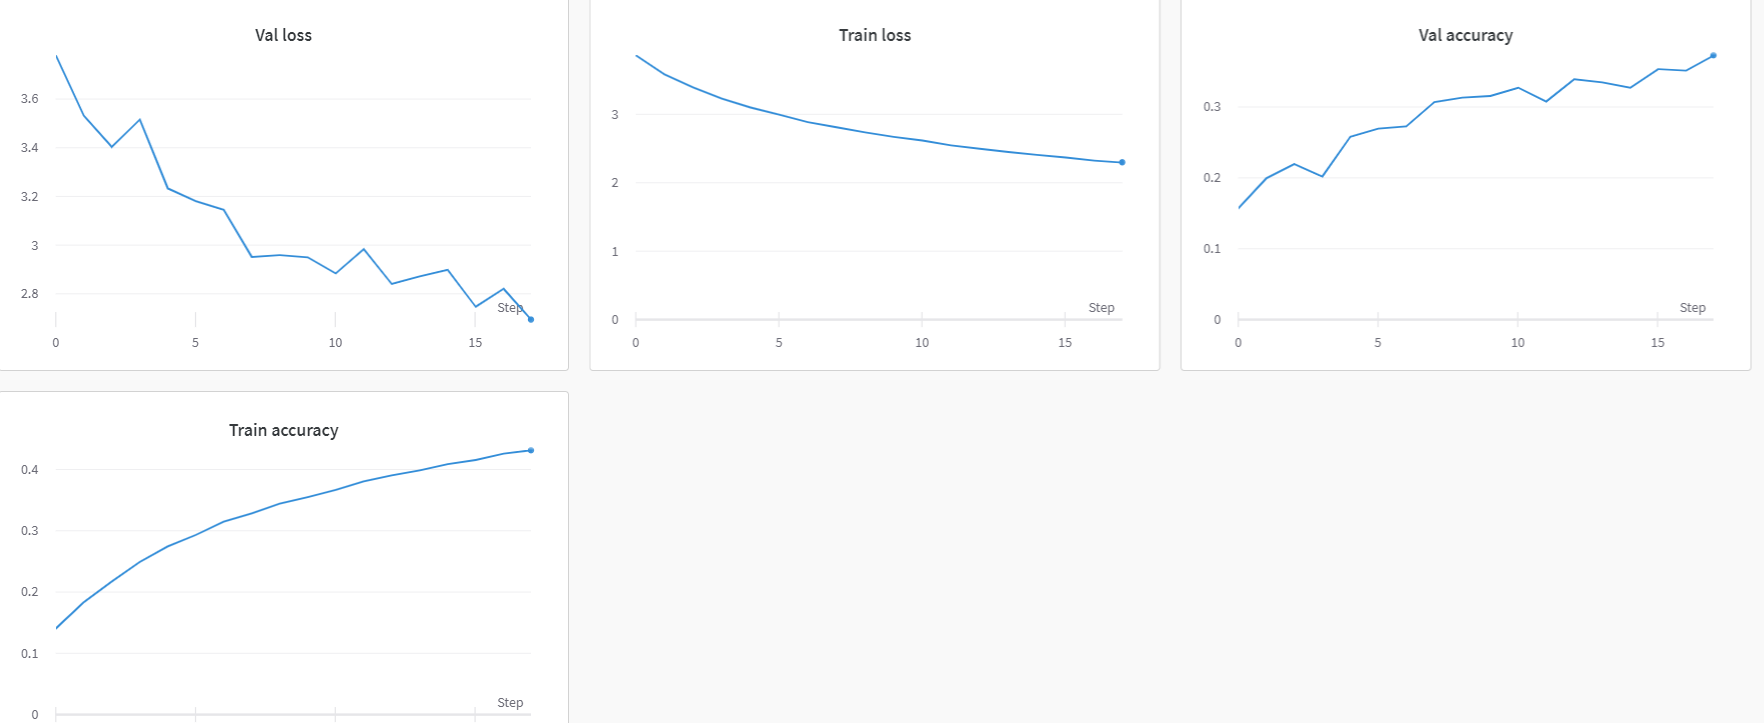

1. За основу я решила взять архитектуру похожую на resnet, для чего был создан отдельный класс MyResBlock, состоящий из 2 блоков, где один блок -  это два слоя вида (conv3, relu, batchnorm)
<br>
Опытным путем было выведено, что оптимальное количество блоков для класса = 2 ( в приведённой статье тоже про 2 слоя говорится). При добавлении каждого следующего слоя качество ухудшалось. На рисунке представлены опыты для 2 блоков в MyResBlock и следующей архитектуры: 4 таких блока для 64 каналов после 3 свёрток, далее maxpool, после чего снова 4 блока для 128 каналов, maxpool, flatten и 2 полносвязных слоя с функцией активации relu и dropout(0.2)


2. При изменении порядка batchnorm и relu после свёртки (в начале batchnorm, затем relu) качество ухудшилось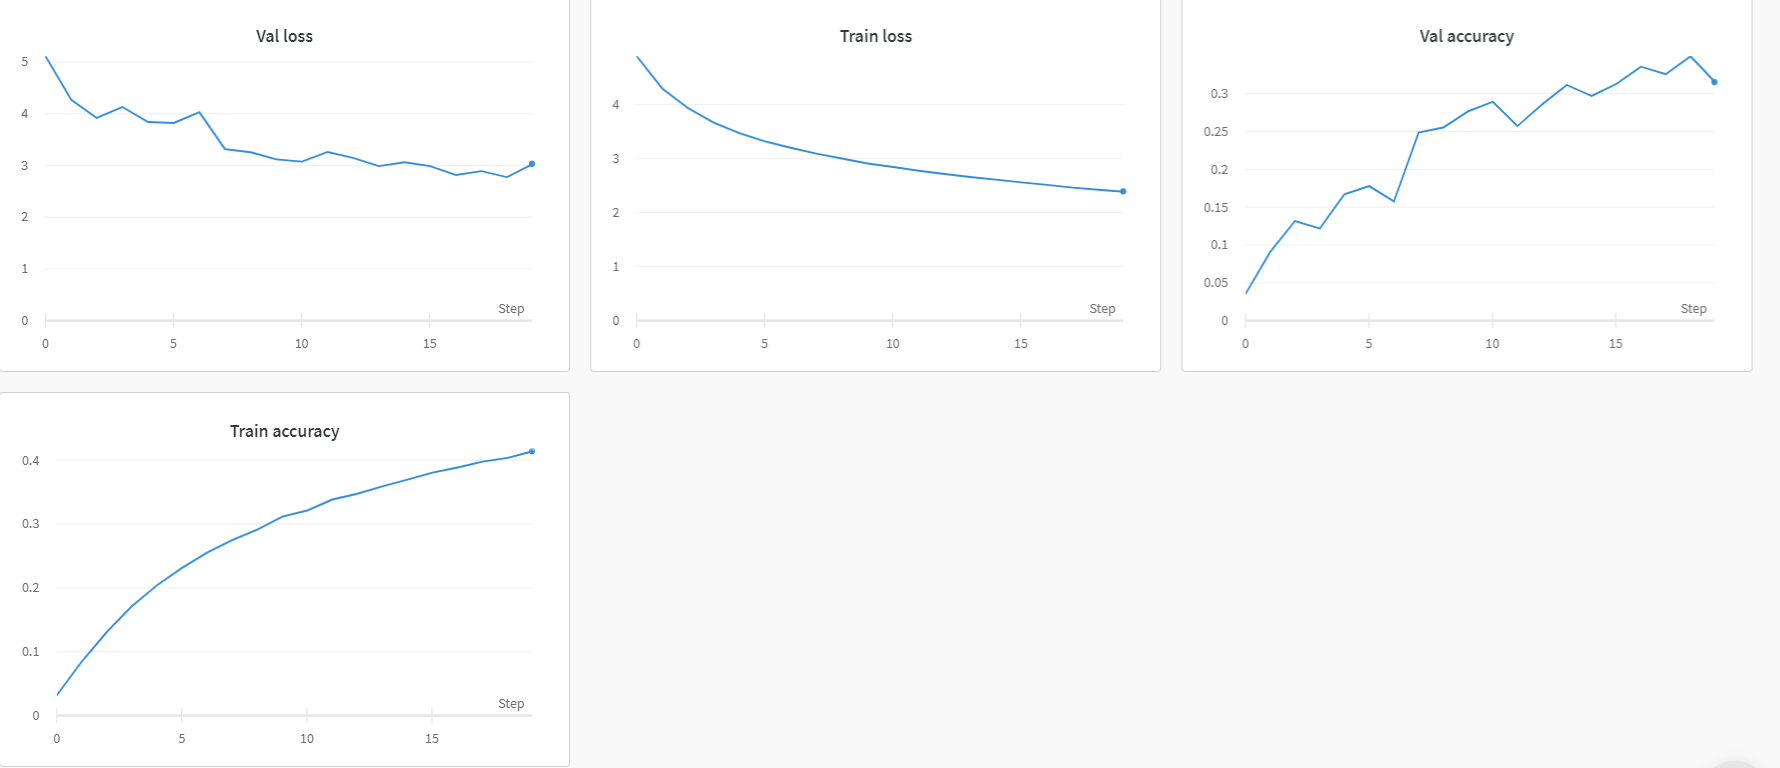

3. Также я пробовала убирать блоки MyResBlock с каналами по 128,качество примерно такое же оставалось, но немного хуже(поэтому в итоговой модели я оставила только 1 такой блок). Также качество снижалось при добавлении блоков с 32 каналами. Изменения в функциях активации (relu->leakyrelu) изменений не давали 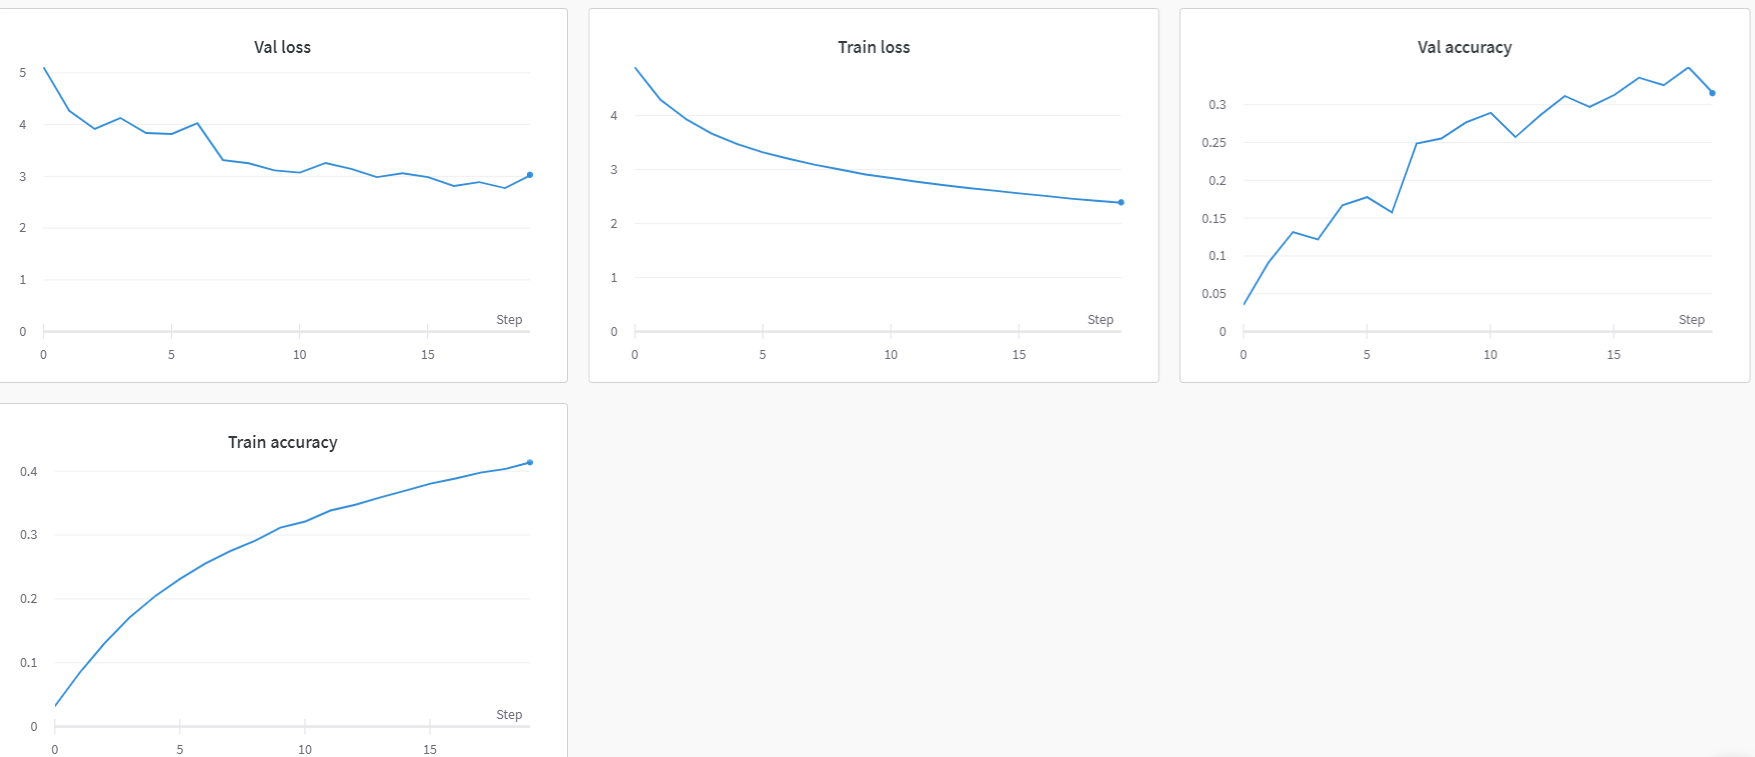

4. Наилучшее качество получалось при похожей на 1 вариант архитектуре, но после 3 блоков MyResBlock и maxpool снова 3 блока MyResBlock по 64 канала (именно это было ключом к успеху, так как блоки по 128 особо изменений не давали, а по 32 ухудшали)


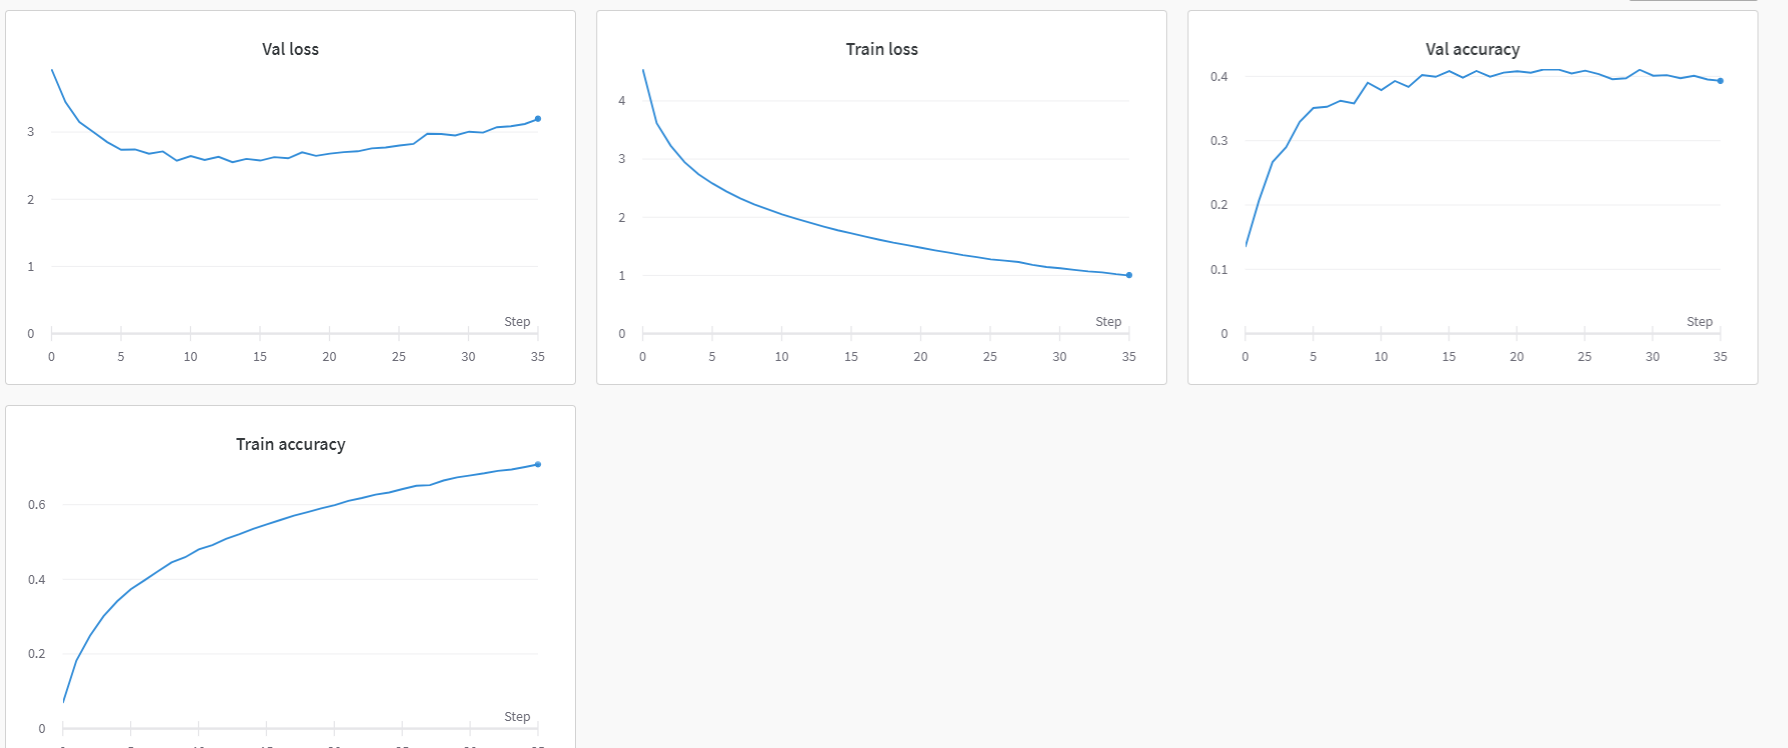